# Análisis computacional de problemas en física estadística sin solución exacta

## Gustavo Adolfo Castrillón Yepes
## gadolfo.castrillon@udea.edu.co
## Instituto de Física, Universidad de Antioquia
## Calle 70 \# 52-21, Apartado Aéreo 1226, Medellín, Colombia.

## Abstract

En el presente trabajo, se llevó a cabo el estudio del potencial anarmónico utilizando dos métodos computacionales: el algoritmo de Trotter y el algoritmo de Metropolis utilizando integrales de camino. Para establecer un esquema adecuado, primero se realizaron pruebas con el potencial armónico cuántico, para el cual se conoce la solución exacta. Se observó que el algoritmo de Trotter puede llegar a ser más eficiente que el de Metropolis. Sin embargo, también se presentaron problemas, como se evidenció al evaluar el método para un pozo de potencial con paredes infinitas, donde el resultado obtenido no coincidió con la proyección teórica. Esto se debió a la forma del potencial.

Tras realizar las verificaciones pertinentes, fue posible, considerando el potencial anarmónico, calcular la densidad de probabilidad de los estados con ambos algoritmos. Ambos métodos funcionaron de manera adecuada. Además, se observó cómo, en función del signo que tenga el término $x^3$, la densidad de probabilidad se desplazará en una dirección preferente, rompiendo la simetría del oscilador armónico. 

## Palabras clave: Oscilador armonico, Temperatura, Métodos de montecarlo.

## Introducción.
Una de las características de los procesos microscópicos es que la mayoría de estos no poseen una solución analítica. En su lugar, es necesario aplicar métodos computacionales para poder obtener una solución aproximada del fenómeno físico que percibimos.

Ahora bien, como es bien sabido, en la cuántica nos centramos en el uso de sistemas físicos cuando estos se encuentran a una temperatura cercana al cero absoluto. Cuando están sometidos a un baño térmico, el problema se complica aún más. Debido a esto, es necesario plantear métodos que sean efectivos para la solución de problemas relacionados con la física estadística cuántica.

En este notebook se plantean dos clases de métodos: el método de matrix squaring y el método de Trotter. Esto se realiza con el fin de estudiar cómo describe cada uno de los métodos diferentes problemas sometidos a baños térmicos. Por ello, vamos a estudiar primero el oscilador armónico cuántico, del cual conocemos su solución analítica. Luego de esto, consideraremos un potencial anarmónico y, al final, se extrapolan ambos algoritmos para un pozo de potencial de lado 𝐿 sometido a un baño térmico.

Lo ideal es plantear algoritmos a partir de los cuales únicamente se requiera conocer la función de la partícula libre y el potencial del problema para hallar la física relacionada con este.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos a considerar que la función de onda libre está dada por una función exponencial normalizada que depende de la temperatura y de las posiciones $x$ y $x_p$. La función tiene la forma:

$$ \rho_{free} (x,x_p,\beta) = \frac{1}{\sqrt{2\pi\beta}}e^{-(x - x_p)^2 / (2\beta)} \text{,}$$

con $\beta$ siendo la temperatura inversa del baño térmico. 

El algoritmo de Trotter va a generar una matriz de tamaño $n\times n$. La operación consiste en realizar cálculos entre el potencial armónico cuántico, sometido a un baño térmico, el cual está descrito por la ecuación:

$$ V(x,\beta) = e^{-\frac{1}{2} \beta x^2} \text{.}$$

Según los cálculos teóricos, para dos posiciones diferentes $x$ y $x_p$, la matriz de densidad está dada por la ecuación: 

$$ \rho (x,x_p,\beta) = e^{-\frac{1}{2}\beta x^2} \rho_{\text{free}} (x,x_{p},\beta) e^{-\frac{1}{2} \beta x_{p}^2} \text{.}$$

Luego, para calcular la distribución de probabilidad y la función gran partición, basta con calcular únicamente los elementos donde $x = x_{p}$, o sea, $\pi(x,\beta) = \rho(x,x,\beta)$ y $\text{Z} = \text{Tr}(\rho (x, x_p,\beta))$. 


Por otro lado, de la teoría tenemos presente que las funciones cuántica y clásica para el oscilador armónico sometido a un baño térmico están dadas por la ecuación:

$$ \pi_{\text{cuántica}}(x, \beta) = \sqrt{\text{tanh} (\beta/2) / \pi} e^{-x^2 \text{tanh}(\beta/2)} \text{,}$$

$$ \pi_{\text{clásica}}(x, \beta) = \sqrt{\beta/2 \pi} e^{-x^2 \beta/2} \text{.}$$

In [2]:
#Producto de dos funciones de onda para partículas libres en dos posiciones x y x_p
def rho_free(x,xp,beta):
    return (np.exp(-(x-xp)**2 /(2.0*beta)) / np.sqrt(2.0*np.pi*beta))
    
#Método de Trotter para dos posiciones diferentes x y x_p. 
def rho_harmonic_trotter(grid,beta):
    return np.array([[rho_free(x,xp,beta)* np.exp(-0.5*beta*0.5*(x**2 + xp**2))\
                      for x in grid] for xp in grid])

#Distribuciones teoricas
#Distribución cuantica
def distribucion_exacta_cuantica(x,betta):
    return np.sqrt(np.tanh(betta/2)/np.pi) * np.exp(- (x**2) * np.tanh(betta/2))
    
#Distribución clásica
def distribucion_exacta_clasica(x,betta):
    return np.sqrt(betta/(2*np.pi))*np.exp(-(betta * x**2)/ 2)

#Para realizar el calculo de R²
def calcular_r2(y_observado, y_predicho):
    # Calcular suma de errores al cuadrado (SSE)
    sse = np.sum((y_observado - y_predicho) ** 2)
    
    # Calcular suma total de cuadrados (SST)
    y_media = np.mean(y_observado)
    sst = np.sum((y_observado - y_media) ** 2)
    
    # Calcular R²
    r2 = 1 - (sse / sst)
    return r2
#Función para calcular la diferencia entre las funciones teoricas y el algoritmo.
def calc_error(counts_, theoretical_values_):
    counts_ = np.array(counts_)
    theoretical_values_ = np.array(theoretical_values_)
    #Vamos a calcular el error cuadrático medio, comparando el valor dado por la función de onda al cuadrado con el método de MCMC
    mse = np.mean((counts_ - theoretical_values_) ** 2)*100
    print(f"\033[1mError cuadrático medio (MSE):\033[0m {mse:.4f} %")
    
    epsilon = 1e-10  # Pequeña constante para estabilidad
    kl_divergence = np.sum(counts_ * np.log((counts_ + epsilon) / (theoretical_values_ + epsilon)))
    print(f"\033[1mKL Divergence:\033[0m {kl_divergence:.4f}")
    
    #Ahora si, por ejemplo, queremos saber que tanto se parecen la teoria a los datos, podemos calcular el coeficiente de correlación
    #para esto, vamos a importar de la libreria sklearn, r2_score. Y comparamos ambos valores
    
    r2 = calcular_r2(counts_, theoretical_values_)
    print(f"\033[1mCoeficiente R²:\033[0m {r2:.4f} ")

In [3]:
x_max = 5.0 #Vamos a considerar un limite de 5. 
nx = 100 #Cantidad de particiones
dx = 2.0 * x_max / (nx - 1) #Tamaño de la partición
x = [i * dx for i in np.arange(-(nx-1),nx/2+1,1)] #Rango de estudio. 
beta_tmp = 2.0**(-5) #Temperatura inicial para imprimir.
beta = 2.0 ** 2 #Termperatura máxima para imprimir.
rho = rho_harmonic_trotter(x,beta_tmp) #Aquí estamos ejecutando el algoritmo de Trotter para una temperatura inicial. 
while beta_tmp < beta: #Realizamos una cantidad de iteraciones donde constantemente estamos variando la temperatura. 
    rho = np.dot(rho,rho)
    rho *= dx
    beta_tmp *=2.0
    print (f'beta: %s -> %s' %(beta_tmp/2.0, beta_tmp)) #Mostramos en pantalla un escalado de la temperatura con el algoritmo de Trotter.

beta: 0.03125 -> 0.0625
beta: 0.0625 -> 0.125
beta: 0.125 -> 0.25
beta: 0.25 -> 0.5
beta: 0.5 -> 1.0
beta: 1.0 -> 2.0
beta: 2.0 -> 4.0


In [4]:
Z = sum(rho[j,j] for j in range(len(x))) * dx #Calculamos la función partición 
pi_of_x = [rho[j,j] / Z for j in range(len(x))] #Calculamos la función de distribución
f = open('data_harm_matrixsquaring_beta' + str(beta) + '.data', 'w') #Creamos una archivo con un nombre especifico que referencia la temperatura

for j in range(len(x)): #Esta línea de codigo es para almacenar los valores. 
    f.write(str(x[j]) + ' ' + str(rho[j,j] /Z) + '\n')
f.close()

In [5]:
val_beta = 4.0 #Consideremos una temperatura inversa alta, o sea, una temperatura baja 
y_clasica = [distribucion_exacta_clasica(i,val_beta) for i in x] #Calculamos los valores teoricos para la función clásica.
y_cuantica = [distribucion_exacta_cuantica(i,val_beta) for i in x] #Calculamos los valores teoricos para la función cuántica.

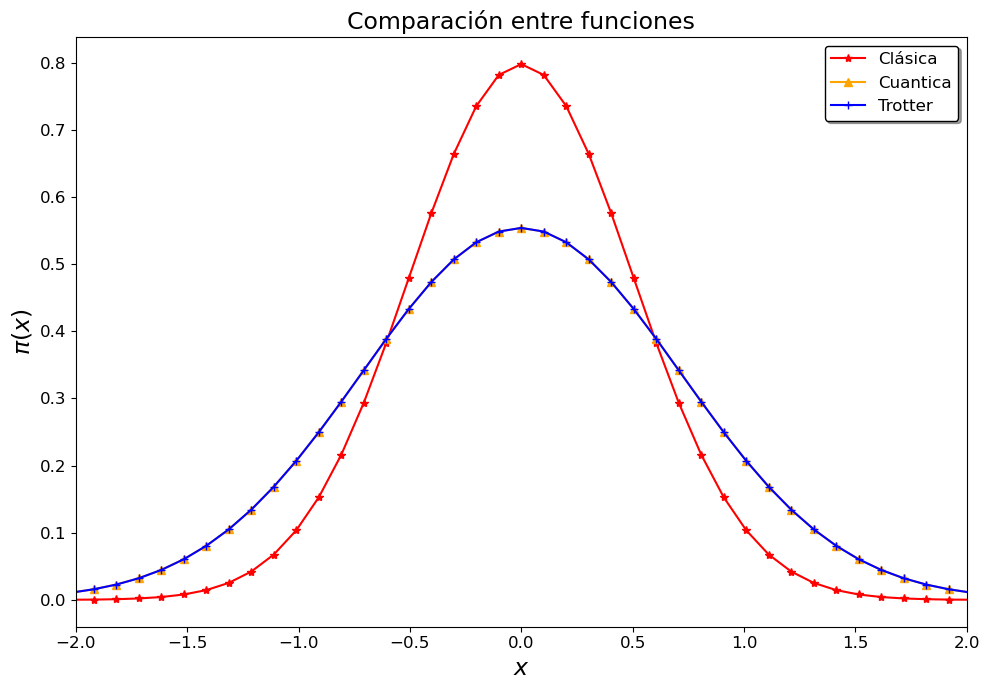


Errores con la función clásica
Error cuadrático medio (MSE): 0.3023 %
KL Divergence: 1.7063
Coeficiente R²: 0.8594 

Errores con la función cuántica
Error cuadrático medio (MSE): 0.0000 %
KL Divergence: 0.0000
Coeficiente R²: 1.0000 


In [6]:
plt.figure(figsize=(10,7))
plt.title('Comparación entre funciones',size=17)
plt.plot(x,y_clasica, '-*',color='red', label='Clásica') #Mostramos la función clásica
plt.plot(x,y_cuantica,'-^',color='orange', label='Cuantica') #Mostramos la función cuántica
plt.plot(x,pi_of_x,'-+',color='blue',label='Trotter') #Gráficamos la función de distribución dada por el algoritmo de Trotter.
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.xlim(-2,2)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.xticks(fontsize=12)    
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
print("")
print("\033[1;31m\033[3;36mErrores con la función clásica\033[0m")
calc_error(pi_of_x, y_clasica)
print("")
print("\033[1;31m\033[3;36mErrores con la función cuántica\033[0m")
calc_error(pi_of_x, y_cuantica)

Es posible notar que, a partir del gráfico y del cálculo de los errores, se puede afirmar que para la función clásica, el método de Trotter logra describir hasta un 85 % de la función. En cambio, para la función cuántica, la coincidencia es tan alta que se obtiene un valor cercano al 100 %.

En general, el valor del 100 % no es exacto; es decir, debería existir alguna diferencia entre ambos resultados. Sin embargo, debido a que la resolución de ambos métodos es tan similar, no se logra apreciar ninguna diferencia significativa.

In [7]:
val_beta = 0.3 #Consideremos una temperatura inversa pequeño, o sea, una temperatura alta
rho = rho_harmonic_trotter(x,val_beta) #Aquí estamos ejecutando el algoritmo de Trotter para una temperatura inicial. 
Z = sum(rho[j,j] for j in range(len(x))) * dx #Calculamos la función partición 
pi_of_x = [rho[j,j] / Z for j in range(len(x))] #Calculamos la función de distribución
y_clasica = [distribucion_exacta_clasica(i,val_beta) for i in x] #Calculamos los valores teoricos para la función clásica.
y_cuantica = [distribucion_exacta_cuantica(i,val_beta) for i in x] #Calculamos los valores teoricos para la función cuántica.

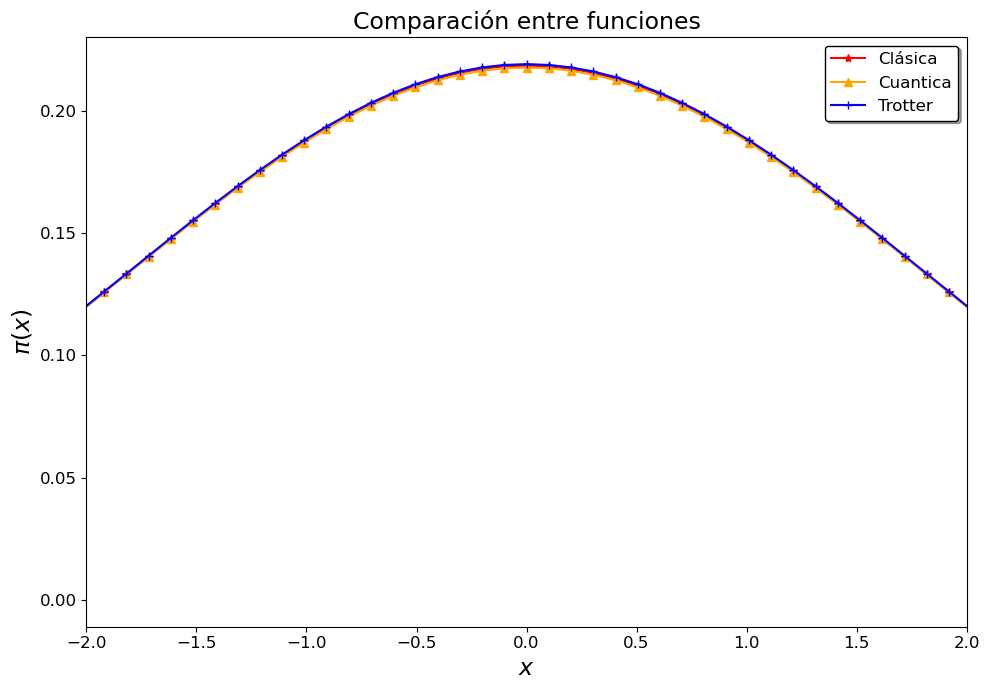


Errores con la función clásica
Error cuadrático medio (MSE): 0.0000 %
KL Divergence: 0.0258
Coeficiente R²: 1.0000 

Errores con la función cuántica
Error cuadrático medio (MSE): 0.0000 %
KL Divergence: 0.0267
Coeficiente R²: 1.0000 


In [8]:
plt.figure(figsize=(10,7))
plt.title('Comparación entre funciones',size=17)
plt.plot(x,y_clasica, '-*',color='red', label='Clásica') #Mostramos la función clásica
plt.plot(x,y_cuantica,'-^',color='orange', label='Cuantica') #Mostramos la función cuántica
plt.plot(x,pi_of_x,'-+',color='blue',label='Trotter') #Gráficamos la función de distribución dada por el algoritmo de Trotter.
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.xlim(-2,2)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.xticks(fontsize=12)    
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
print("")
print("\033[1;31m\033[3;36mErrores con la función clásica\033[0m")
calc_error(pi_of_x, y_clasica)
print("")
print("\033[1;31m\033[3;36mErrores con la función cuántica\033[0m")
calc_error(pi_of_x, y_cuantica)

Nótese que, en este caso, cuando se considera una temperatura alta, ambas funciones teóricas se ajustan muy bien a los resultados obtenidos por el algoritmo de Trotter, permitiendo así describir con gran precisión las funciones, alcanzando una coincidencia del 100 %.

### Valor esperado de la energía

El valor promedio de la energía, o valor esperado de la energía, está dado por: 

$$\langle E \rangle = - \frac{\partial \text{Ln} (Z)}{\partial \beta} \text{.}$$

Como estamos resolviendo este problema de forma numérica, es necesario retomar la definición de derivada para obtener la derivada de esta función. Este valor esperado de la energía se aproxima al valor teórico a partir de la siguiente relación:

$$ \frac{\partial \text{ln}Z}{\partial \beta} \simeq \frac{\text{Ln} Z(\beta + \Delta \beta) - \text{Ln}Z(\beta)}{\Delta \beta}$$ 

Vamos a considerar un rango de temperaturas y analizar cómo cambia la energía esperada y el logaritmo de la función de partición en función de la temperatura inversa. Para esto, se plantean las siguientes líneas de código.

In [9]:
betas = np.logspace(0,2,100) #Vamos a tomar 100 puntos en escala logaritmica entre 0 y 2 de temperatura inversa.
#0 -> 10⁰ = 1 y 2-> 10² = 100 
x = np.linspace(-2,2,200) #Arreglo de las posiciones. 
Z = [] 
for beta in betas:  
    rho = rho_harmonic_trotter(x,beta) #Usamos Trotter para calcular el rho. 
    z = sum(rho[j,j] for j in range(len(x))) #Calculamos el valor de Z. 
    Z.append(z) #Almacenamos ese valor. 

In [10]:
n = len(betas) - 1 #Cómo deseamos hacer una comparación del paso de betta, tendremos n - 1 puntos. 
lnz = [] #Para almacenar el logaritmo de la función partición. 
data = [] # Para almacenar la energía esperada. 
for i in range(n):
    deltabetas = betas[i+1] - betas[i] #Calculamos el delta beta 
    lnz.append(np.log(Z[i])) #Calculamos el logaritmo y lo guardamos 
    deltaZ = np.log(Z[i+1]) - np.log(Z[i]) #Calculamos la diferencia entre el logaritmo de dos posiciones contiguas. 
    data.append(-deltaZ/deltabetas)#Calculamos el valor esperado de la energía y lo almacenamos. 

/tmp/ipykernel_22368/2501706724.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,110)


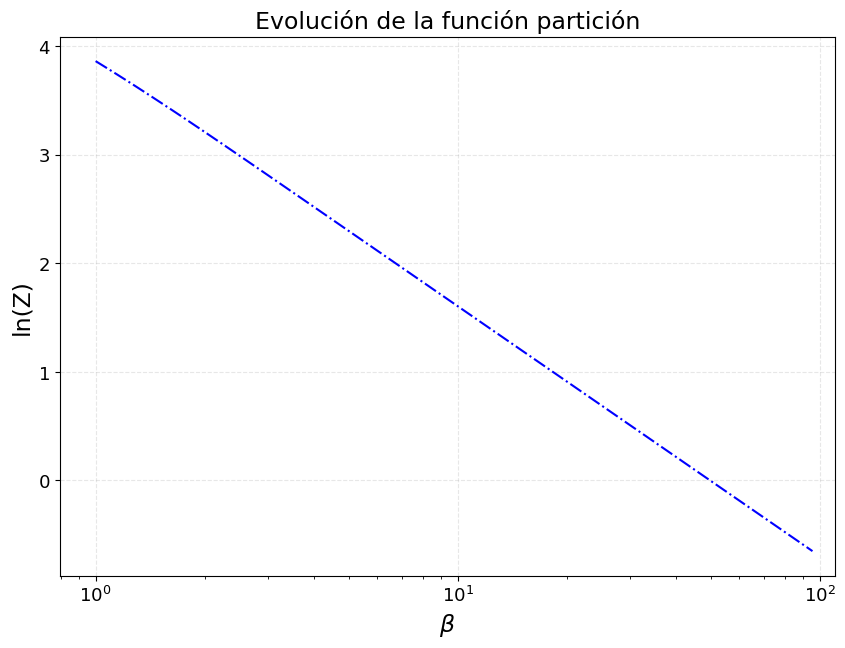

In [11]:
plt.figure(figsize=(10,7))
plt.plot(betas[0:-1], lnz,'-.',color='blue') #Graficamos la ecuación logaritmo natural de la función partición vs beta
plt.title("Evolución de la función partición",size=17)
plt.xscale('log') #Variación logarimica de los datos. 
plt.yscale('linear')
plt.xlabel(r'$\beta$',size=17)
plt.ylabel(r'ln(Z)',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0,110)
plt.show()

Nótese que, cuando la temperatura inversa es muy grande, estamos considerando valores de temperatura muy pequeños. En el gráfico se puede observar que esta función se comporta prácticamente como una línea recta cuando se utiliza una escala lineal. Esto nos indica que, en una escala normal, la función presenta un comportamiento con dependencia logarítmica en función de los valores de $\beta$.

En otras palabras, nos referimos a que el logaritmo de la función de partición decrece como una función logarítmica.

/tmp/ipykernel_22368/4134486565.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,110)


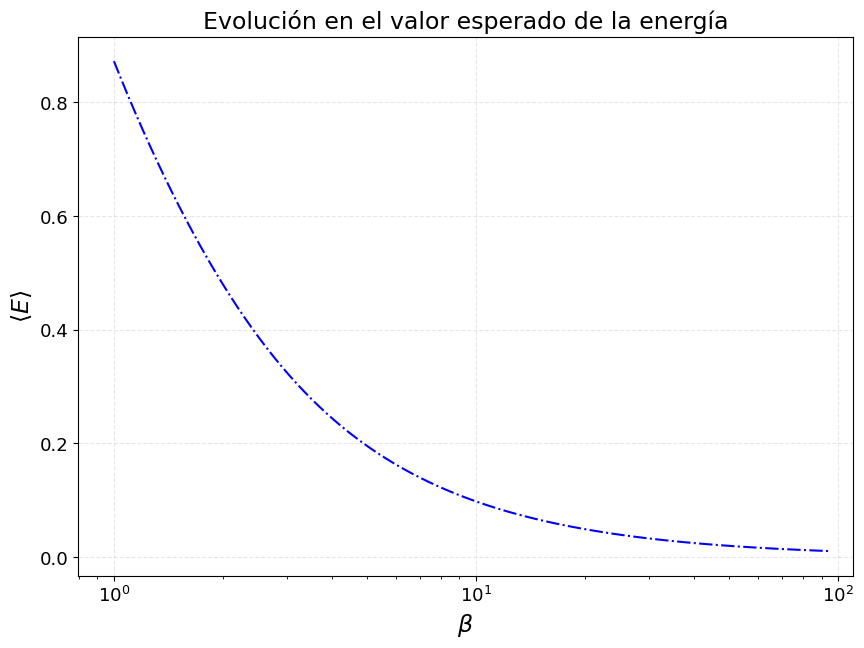

In [12]:
plt.figure(figsize=(10,7))
plt.title('Evolución en el valor esperado de la energía',size=17)
plt.plot(betas[0:-1], data,'-.',color='blue') #Graficamos el valor esperado de la energía. 
plt.xscale('log')
plt.yscale('linear')
plt.xlabel(r'$\beta$',size=17)
plt.ylabel(r'$\langle E \rangle$',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0,110)
plt.show()

Como se esperaría, cuando se tienen valores de temperatura muy altos, es decir, valores de $\beta$ muy pequeños, el valor esperado de la energía se incrementa exponencialmente hacia valores altos. Por otro lado, cuando $\beta$ es grande, la energía del oscilador tiende a un valor cercano a cero.

Esto nos indica que, a menor temperatura del baño térmico, menor será la energía esperada de la partícula sometida a dicho entorno.

## Matriz Squaring. 
Ahora vamos a considerar el método de matriz squaring para calcular la solución del oscilador armónico.
Para esto, se decide construir un algoritmo de Metrópolis que utiliza la teoría de los caminos de Feynman para calcular la distribución de probabilidad de un potencial dado. En este caso, los pesos estarán dados por la multiplicación de dos funciones de onda en dos posiciones diferentes, y estas estarán multiplicadas por el mismo potencial considerado anteriormente en el algoritmo de Trotter.

La diferencia entre este método y el anterior es que aquí se considera un análisis aleatorio para describir las funciones, en lugar de evaluarlas sobre una malla.

Una posible ventaja respecto al otro método es que, en algunos puntos donde la función presente discontinuidades, utilizar un análisis aleatorio no afectaría el cálculo de la distribución. Sin embargo, en el algoritmo de Trotter es necesario que el potencial sea continuo y se evalúe sobre una malla "continua", por lo que si existen regiones que no puedan ser evaluadas, podrían surgir problemas al aplicar dicho método.

In [13]:
def rho_free(x,y,beta):
    return np.exp(-(x-y)**2 / (2.0*beta))

def potencial(x,dtau):
    return np.exp(-0.5*dtau*x**2)

In [14]:
beta = 4.0 #Temperatura inversa. 
N = 10 #Cuantos puntos vamos a considerar en la malla. 
dtau = beta/N #Calculamos una pequeña perturbación en la energía 
delta = (1/beta) #El empuje que tenga va a ser proporcional a la temperatura.
n_steps = 1000000 #Cantidad de iteraciones 
x = [0.0] * N 
x_samples0 = [] 
paths = []

for step in range(n_steps):
    k = np.random.randint(1,N-1) #Generamos un k aleatorio, dejando fijo el valor inicial y el final.
    knext , kprev = (k+1) % N, (k-1)%N #Calculamos los vecinos.
    x_new = x[k] + np.random.uniform(-delta,delta) #Generamos un pequeño empuje en las posiciones. 
    old_weight = (rho_free(x[knext], x[k], dtau) * rho_free(x[k] , x[kprev], dtau)*\
                potencial(x[k],dtau)) #Calculamos la probabilidad para la antigua posición. 
    new_weight = (rho_free(x[knext], x_new, dtau)* rho_free(x_new, x[kprev], dtau)*\
                potencial(x_new,dtau)) #Calculamos la probabilidad para la nueva posición.

    if np.random.uniform(0.0,1.0) < new_weight / old_weight: #Análizamos si es posible realizar un salto o no según las probabilidades.
        x[k] = x_new #En caso de ser afirmativo aceptamos el valor. 
        
    if step % 10 == 0: #Cada 10 pasos almacenamos el valor, esto para evitar la correlación. 
        #x_samples0.append(x[0]) 
        paths.append(x.copy()) #Guardamos los valores 

paths_elements = np.array(paths).T #Convertimos los datos a un array y aplicamos la transpuesta para poder obtener en función de k. 
otros_elementos = paths_elements.copy()

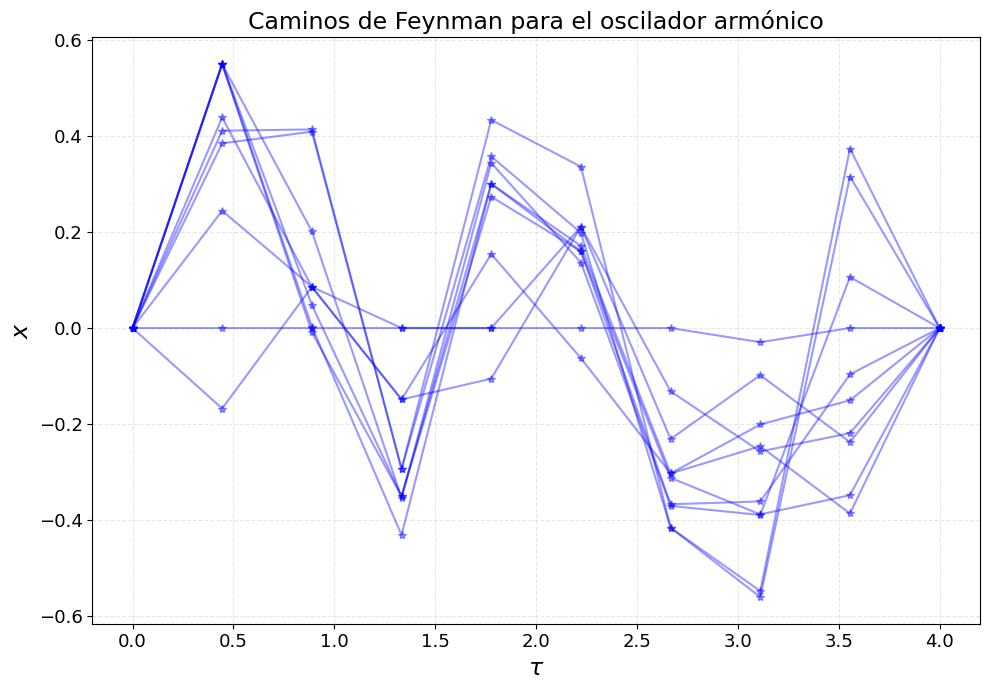

In [15]:
# Diagrama de caminos de Feynman (β vs. x)
tau = np.linspace(0, beta, N)
plt.figure(figsize=(10,7))
for path in paths[N-10:N]:  # Graficar solo los útlimos caminos para claridad
    plt.plot(tau, path,'-*', color='blue', alpha=0.4)
plt.xlabel(r'$\tau$',size=17)
plt.ylabel('$x$',size=17)
plt.title('Caminos de Feynman para el oscilador armónico',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

Como se está siguiendo la idea de resolver el problema utilizando la teoría de los caminos de Feynman, es necesario considerar que los puntos inicial y final del camino son el mismo. Por eso, es posible notar que, en el gráfico anterior, ambos puntos están en cero, por ejemplo.

Además, observamos que estamos dividiendo la temperatura inversa $\beta$ en varios segmentos (10), donde cada posición es perturbada y se calcula una cantidad de caminos diferentes que pueden ser analizados. Es posible observar también que, dado que $\beta = 4.0$, estos caminos solo llegan hasta un $\tau = 4.0$.

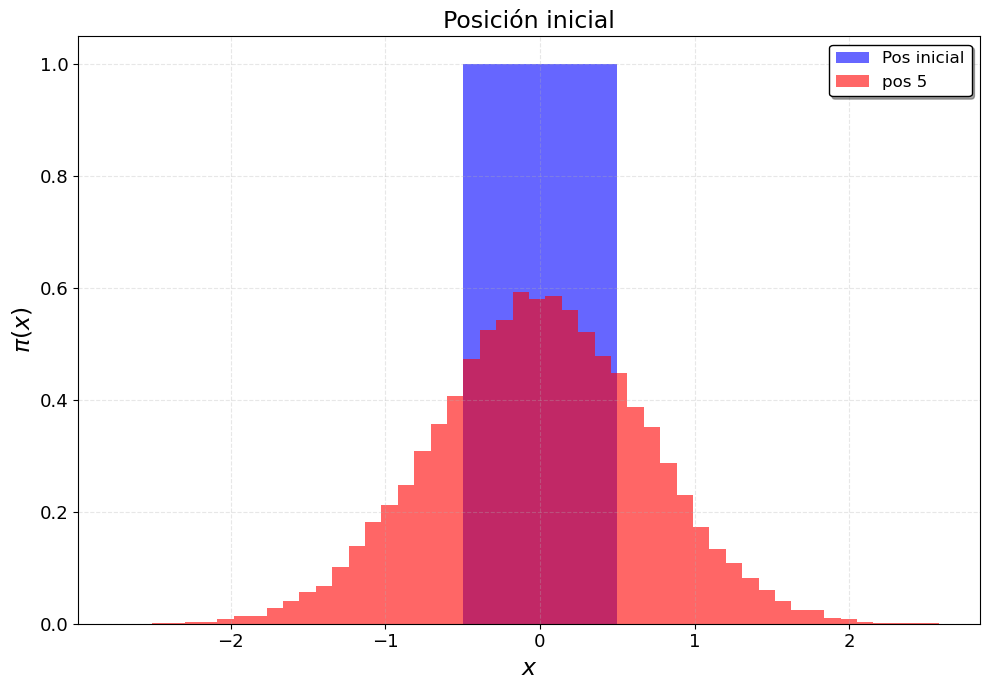

In [16]:
k = 5
x_samples0 = paths_elements[0] #Gráficamos la posición K = 0
x_samplesk = paths_elements[k] #Gráficamos la posición K = 5 
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=1, density=True, alpha=0.6, color='blue',label='Pos inicial')
plt.hist(x_samplesk, bins=50, density=True, alpha=0.6, color='red', label=f'pos {k}')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.show()

En el gráfico anterior, tenemos dos valores. El primero corresponde a la posición cero, la cual no cambia sin importar cuántas iteraciones realicemos. Por otro lado, el gráfico de color rojo muestra cómo se comporta la posición en $x$ para el elemento $k=5$. Estas barras rojas tienen un comportamiento similar al de una campana de Gauss.

Ahora, cuando disminuimos la temperatura inversa, es decir, cuando aumentamos la temperatura, el resultado es el siguiente:

In [17]:
beta = 1.0 #Temperatura inversa. 
N = 10 #Cuantos puntos vamos a considerar en la malla. 
dtau = beta/N #Calculamos una pequeña perturbación en la energía 
delta = (1/beta) #El empuje que tenga va a ser proporcional a la temperatura.
n_steps = 1000000 #Cantidad de iteraciones 
x = [0.0] * N 
x_samples0 = [] 
paths = []

for step in range(n_steps):
    k = np.random.randint(1,N-1) #Generamos un k aleatorio, dejando fijo el valor inicial y el final.
    knext , kprev = (k+1) % N, (k-1)%N #Calculamos los vecinos.
    x_new = x[k] + np.random.uniform(-delta,delta) #Generamos un pequeño empuje en las posiciones. 
    old_weight = (rho_free(x[knext], x[k], dtau) * rho_free(x[k] , x[kprev], dtau)*\
                potencial(x[k],dtau)) #Calculamos la probabilidad para la antigua posición. 
    new_weight = (rho_free(x[knext], x_new, dtau)* rho_free(x_new, x[kprev], dtau)*\
                potencial(x_new,dtau)) #Calculamos la probabilidad para la nueva posición.

    if np.random.uniform(0.0,1.0) < new_weight / old_weight: #Análizamos si es posible realizar un salto o no según las probabilidades.
        x[k] = x_new #En caso de ser afirmativo aceptamos el valor. 
        
    if step % 10 == 0: #Cada 10 pasos almacenamos el valor, esto para evitar la correlación. 
        #x_samples0.append(x[0]) 
        paths.append(x.copy()) #Guardamos los valores 

paths_elements2 = np.array(paths).T #Convertimos los datos a un array y aplicamos la transpuesta para poder obtener en función de k. 

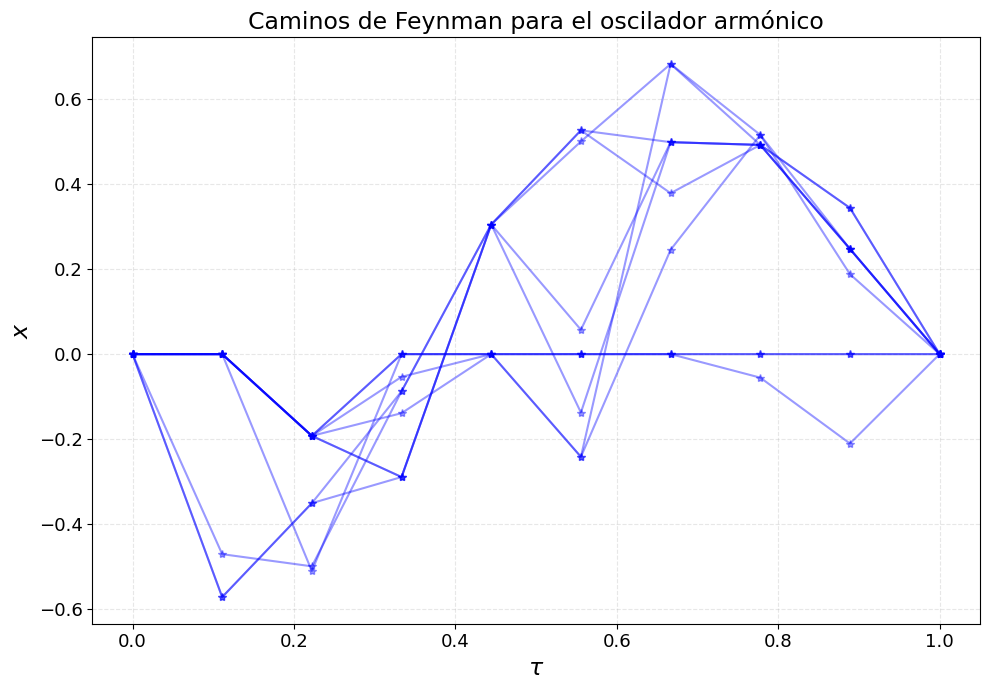

In [18]:
# Diagrama de caminos de Feynman (β vs. x)
tau = np.linspace(0, beta, N)
plt.figure(figsize=(10,7))
for path in paths[N-10:N]:  # Graficar solo los útlimos caminos para claridad
    plt.plot(tau, path,'-*', color='blue', alpha=0.4)
plt.xlabel(r'$\tau$',size=17)
plt.ylabel('$x$',size=17)
plt.title('Caminos de Feynman para el oscilador armónico',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

Observamos un comportamiento de los caminos de Feynman similar al de la temperatura anterior. La única diferencia, aunque no tan notable, es que estos caminos parecen tener una menor intensidad. Sin embargo, en el problema no estamos considerando que la perturbación al sistema dependa de la temperatura, por lo que este fenómeno descrito puede deberse únicamente a la aleatoriedad.

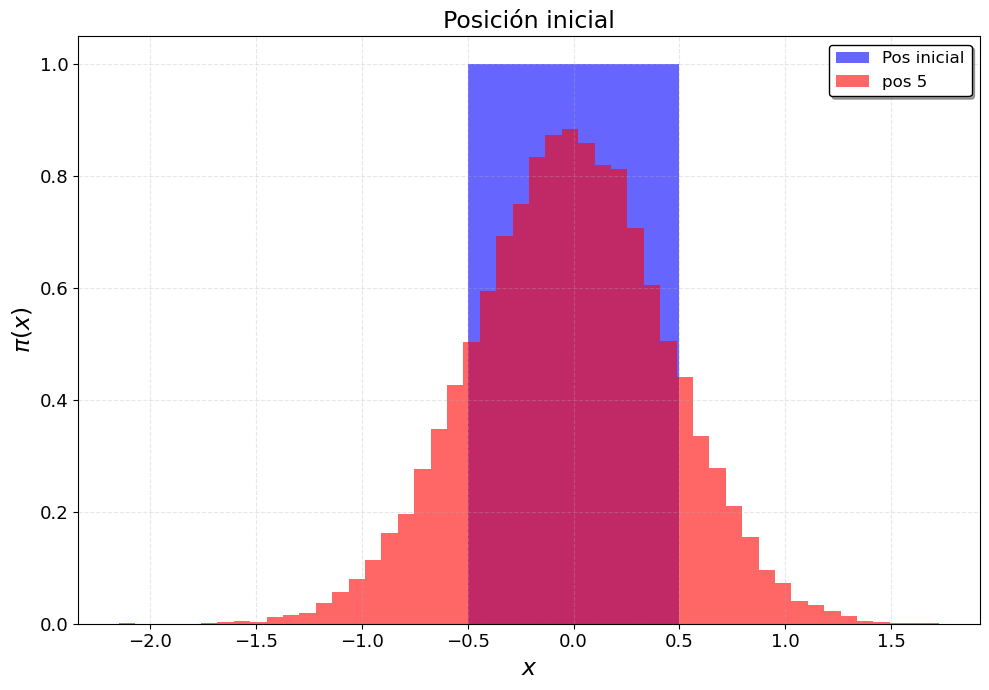

In [19]:
k = 5
x_samples0 = paths_elements2[0] #Gráficamos la posición K = 0
x_samplesk = paths_elements2[k] #Gráficamos la posición K = 5 
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=1, density=True, alpha=0.6, color='blue',label='Pos inicial')
plt.hist(x_samplesk, bins=50, density=True, alpha=0.6, color='red', label=f'pos {k}')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.show()

Es posible observar que, en este caso, la zona roja tiende a tener mayores valores conforme nos acercamos a cero. Esto sería lo esperado, ya que, como vimos en el algoritmo de Trotter, a mayor temperatura, mayor será el comportamiento clásico del sistema.

In [20]:
def read_file(filename): #El siguiente codigo permite cargar archivos
    list_x = []
    list_y = []
    with open(filename) as f: 
        for line in f: 
            x, y = line.split()
            list_x.append(float(x))
            list_y.append(float(y))
    f.close()
    return list_x, list_y  

#Vamos a gráficar la función del estado inical para el oscilador armónico
def psi0(x):
    return (1/np.pi**(1/4)) * np.exp(- (x**2)/2)

In [21]:
data = read_file('data_harm_matrixsquaring_beta4.0.data') #Cargamos los datos para beta = 4.0
x_data = np.linspace(-2,2,100)
y_data = psi0(x_data)

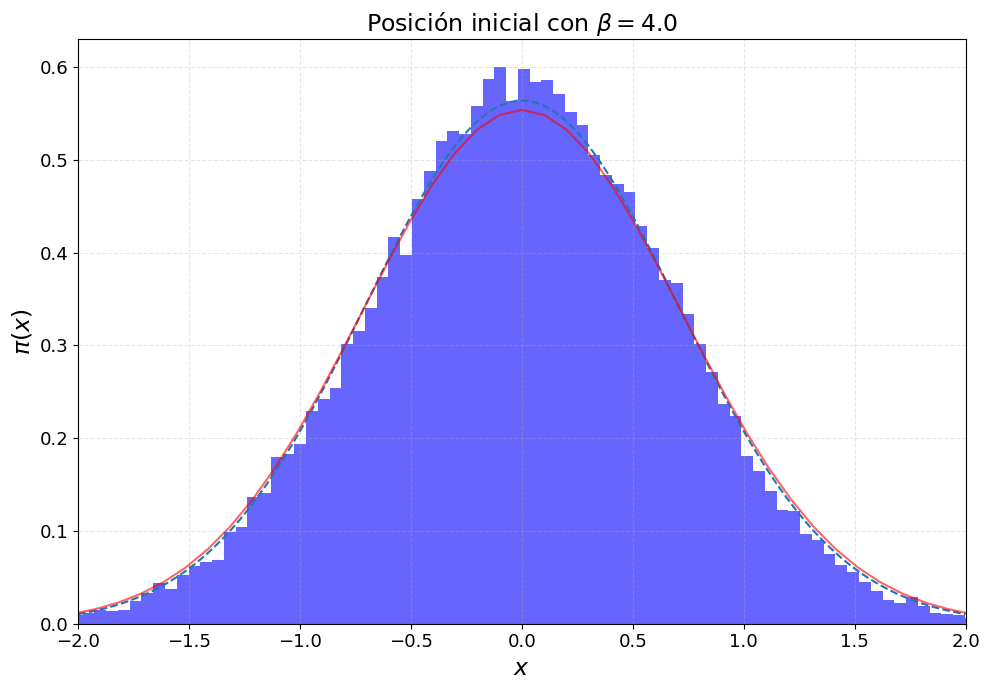

In [22]:
x_samples0 = otros_elementos[k]
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=100, density=True, alpha=0.6, color='blue')
plt.plot(x_data, y_data**2, '--')
plt.plot(data[0],data[1], alpha=0.6, color='red')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial con $\beta = 4.0$',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(-2,2)
plt.tight_layout()
plt.show()

En este gráfico, es posible observar cómo la función teórica ($\psi_{0}$) y la línea calculada por el algoritmo de Trotter se asemejan bastante a los resultados esperados por este método de Metrópolis con integrales de Feynman. Las líneas son muy similares.

## Oscilador anarmónico

En este caso, vamos a considerar un oscilador anarmónico, dado por el potencial:

$$ V(x) = \frac{1}{2} x^2 - x^3 + x^4 $$

Aplicaremos el método de Trotter y el algoritmo de Metrópolis, y compararemos además sus soluciones con las del oscilador armónico.

In [23]:
def potencialA(x): #Potencial anarmonico
    return x**2 / 2 - x**3 + x**4
    
#Algoritmo de Trotter para el potencial anarmonico.
def rho_anarmonic_trotter(grid,beta):
    return np.array([[rho_free(x,xp,beta)* np.exp(-0.5*beta*0.5*(potencialA(x) + potencialA(xp)))\
                      for x in grid] for xp in grid])
    
#Pesos para el algoritmo de metropolis. 
def prob(x,dtau):
    return np.exp(-0.5*dtau*potencialA(x))

In [24]:
x_max = 5.0 #Rango máximo
nx = 100 
dx = 2.0 * x_max / (nx - 1)
x = [i * dx for i in np.arange(-(nx-1),nx/2+1,1)]
beta_tmp = 2.0**(-5)
beta = 2.0 ** 2
rho = rho_anarmonic_trotter(x,beta_tmp) #Calculamos el rho para el anarmonico.
Z = sum(rho[j,j] for j in range(len(x))) * dx #Calculamos la función partición.
pi_of_x2 = [rho[j,j] / Z for j in range(len(x))] #Calculamos la densidad de probabilidad.

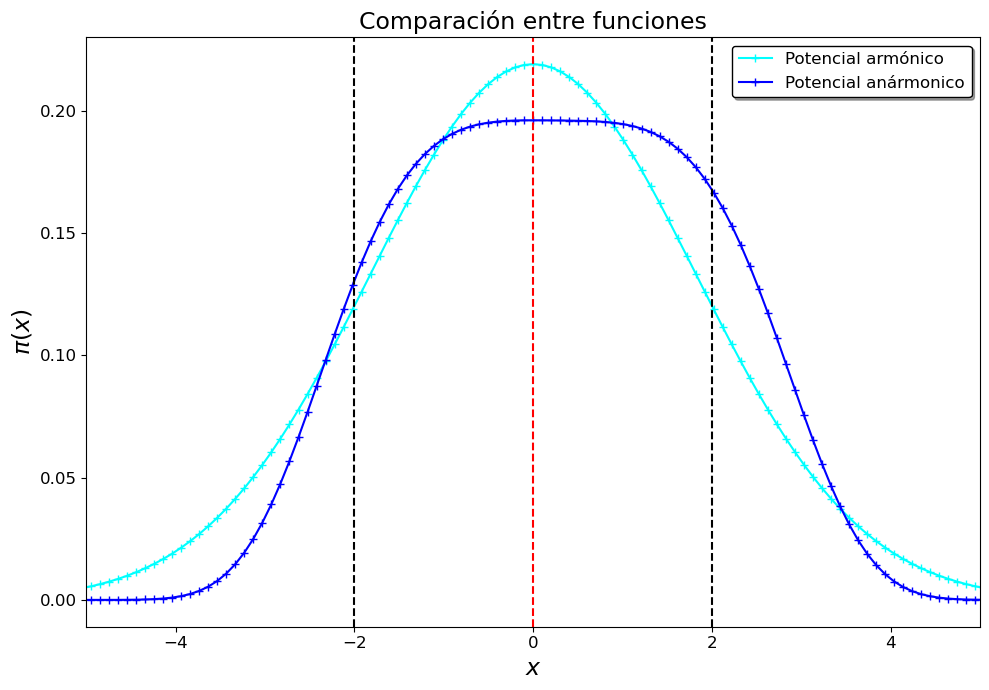

In [25]:
plt.figure(figsize=(10,7))
plt.title('Comparación entre funciones',size=17)
plt.plot(x,pi_of_x,'-+',color='cyan',label='Potencial armónico')
plt.plot(x,pi_of_x2,'-+',color='blue',label='Potencial anármonico')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.xlim(-5,5)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.xticks(fontsize=12)    
plt.yticks(fontsize=12)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=2, color='black', linestyle='--')
plt.axvline(x=-2, color='black', linestyle='--')
plt.tight_layout()
plt.show()

Aunque es difícil de percibir, las soluciones arrojadas por el algoritmo de Trotter para el potencial anarmónico muestran cierta asimetría en la solución. Esto se puede percibir de manera más adecuada con las líneas verticales que se muestran en el gráfico. Cuando tenemos el potencial armónico, su punto máximo está en 0 y existe una simetría. Sin embargo, para el potencial anarmónico, se observa una asimetría, como se puede ver en los puntos $-2$ y $2$.

In [26]:
beta = 4.0
N = 10
dtau = beta/N
delta = 1.0
n_steps = 1000000
x = [0.0] * N 
x_samples0 = [] 
x_samplesk = []
k_values = 4
x_samplesN = []
paths = []

for step in range(n_steps):
    k = np.random.randint(1,N-1)
    knext , kprev = (k+1) % N, (k-1)%N
    x_new = x[k] + np.random.uniform(-delta,delta)
    old_weight = (rho_free(x[knext], x[k], dtau) * rho_free(x[k] , x[kprev], dtau)*\
                prob(x[k],dtau))
    new_weight = (rho_free(x[knext], x_new, dtau)* rho_free(x_new, x[kprev], dtau)*\
                prob(x_new,dtau))

    if np.random.uniform(0.0,1.0) < min(1,new_weight / old_weight):
        x[k] = x_new
        
    if step % 10 == 0:
        x_samples0.append(x[0])
        x_samplesk.append(x[k_values])
        x_samplesN.append(x[-1])
negativo = x_samplesk.copy()

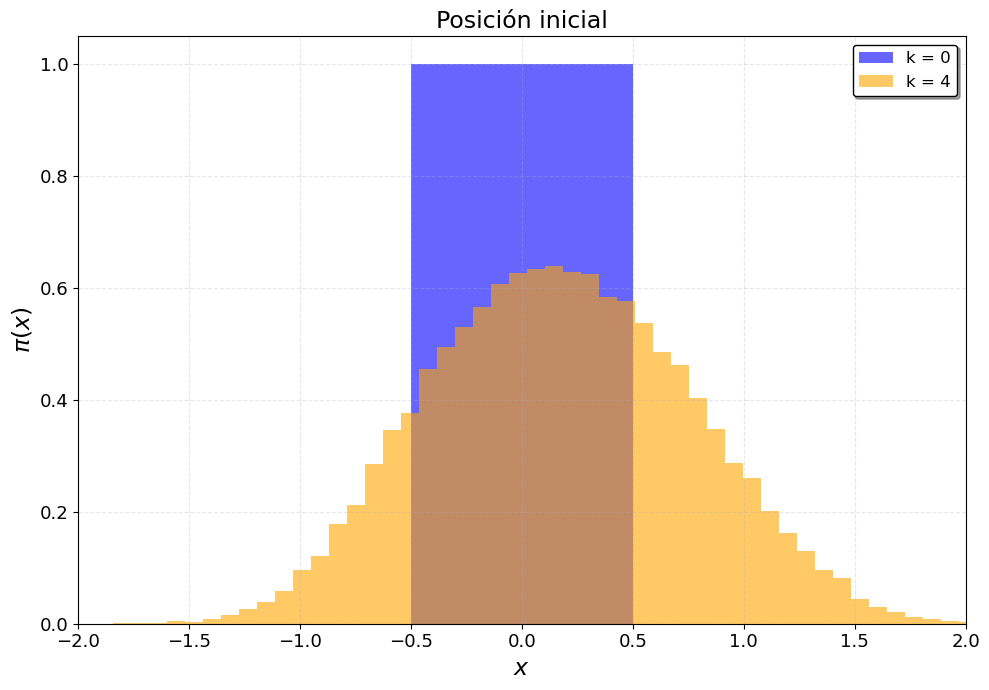

In [27]:
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=1, density=True, alpha=0.6, color='blue', label='k = 0')
plt.hist(x_samplesk, bins=50, density=True, alpha=0.6, color='orange',label=f'k = {k_values}')
#plt.hist(x_samplesN, bins=50, density=True, alpha=0.6, color='red')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(-2,2)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.tight_layout()
plt.show()

En este gráfico, es posible observar cómo, para un $k=4$, la distribución de probabilidad presenta una asimetría hacia la derecha, lo que significa que existe una mayor probabilidad de encontrar la partícula en una posición positiva que en una negativa. Esto se debe a que el término $x^3$ es el que introduce la asimetría al potencial, ya que es un término impar. Este término determina hacia qué dirección se proyectan las probabilidades.

Obsérvese en la siguiente línea de código que, cuando tenemos un término $+x^3$, se genera un desplazamiento de las probabilidades hacia la izquierda.

In [28]:

def potencialA(x): #Potencial anarmonico
    return x**2 / 2 + x**3 + x**4
    
#Algoritmo de Trotter para el potencial anarmonico.
def rho_anarmonic_trotter(grid,beta):
    return np.array([[rho_free(x,xp,beta)* np.exp(-0.5*beta*0.5*(potencialA(x) + potencialA(xp)))\
                      for x in grid] for xp in grid])
    
#Pesos para el algoritmo de metropolis. 
def prob(x,dtau):
    return np.exp(-0.5*dtau*potencialA(x))
    
beta = 4.0
N = 10
dtau = beta/N
delta = 1.0
n_steps = 1000000
x = [0.0] * N 
x_samples0 = [] 
x_samplesk = []
k_values = 4
x_samplesN = []
paths = []

for step in range(n_steps):
    k = np.random.randint(1,N-1)
    knext , kprev = (k+1) % N, (k-1)%N
    x_new = x[k] + np.random.uniform(-delta,delta)
    old_weight = (rho_free(x[knext], x[k], dtau) * rho_free(x[k] , x[kprev], dtau)*\
                prob(x[k],dtau))
    new_weight = (rho_free(x[knext], x_new, dtau)* rho_free(x_new, x[kprev], dtau)*\
                prob(x_new,dtau))

    if np.random.uniform(0.0,1.0) < min(1,new_weight / old_weight):
        x[k] = x_new
        
    if step % 10 == 0:
        x_samples0.append(x[0])
        x_samplesk.append(x[k_values])
        x_samplesN.append(x[-1])

positivo = x_samplesk.copy()

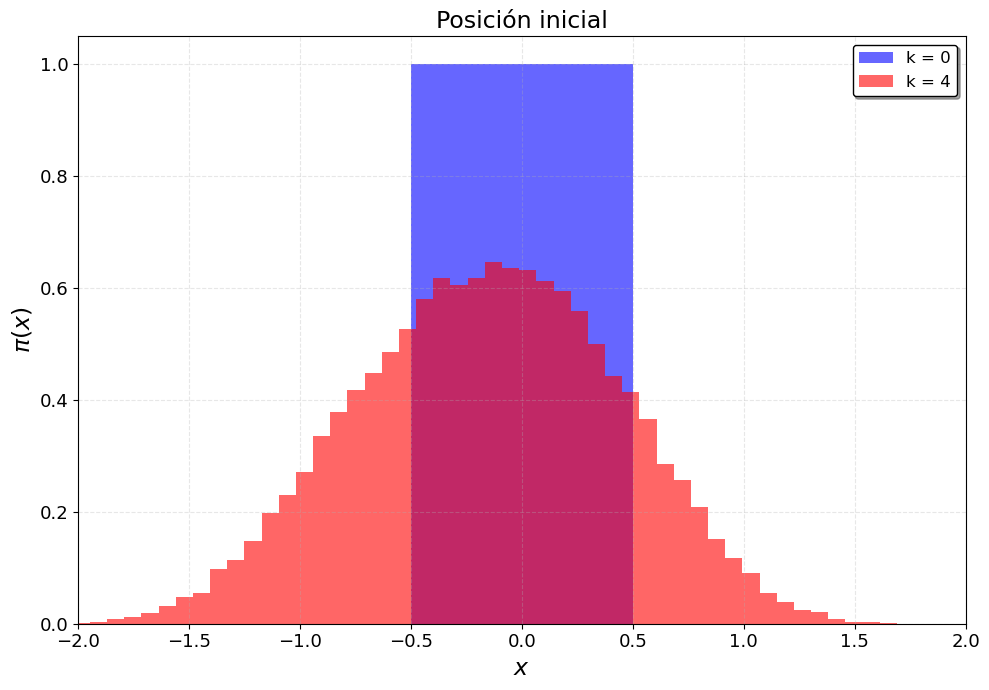

In [29]:
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=1, density=True, alpha=0.6, color='blue', label='k = 0')
plt.hist(x_samplesk, bins=50, density=True, alpha=0.6, color='red',label=f'k = {k_values}')
#plt.hist(x_samplesN, bins=50, density=True, alpha=0.6, color='red')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(-2,2)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.tight_layout()
plt.show()

En las barras de color rojo es posible observar que las probabilidades esta vez se desplazaron hacia la izquierda, es decir, existe una mayor probabilidad de encontrar partículas en posiciones negativas que en posiciones positivas.

## Potencial infinito. 

Es posible extrapolar estos algoritmos a un método general. Uno de ellos consiste en considerar un potencial infinito de la siguiente manera:

In [30]:
def potencial_infinite_well(x,L=5.0):
    #En caso de estar por fuera del muro, vamos a devolver psi = 0.
    if np.abs(x) > L/2:
        return np.inf
    else:
        return 0

#Algoritmo de Trotter para el potencial anarmonico.
def rho_infinite_well_trotter(grid,beta):
    return np.array([[rho_free(x,xp,beta)* np.exp(-0.5*beta*(potencial_infinite_well(x) + potencial_infinite_well(xp)))\
                      for x in grid] for xp in grid])
    
#Pesos para el algoritmo de metropolis. 
def prob(x,dtau):
    return np.exp(-0.5*dtau*potencial_infinite_well(x))

In [31]:
x_max = 5 #Rango máximo
nx = 100 
dx = 2.0 * x_max / (nx - 1)
x = [i * dx for i in np.arange(-(nx-1)/2,nx/2+1,1)]
beta_tmp = 2.0**(-5)
beta = 2.0 ** 2
rho = rho_infinite_well_trotter(x,beta_tmp) #Calculamos el rho para el anarmonico.
Z = sum(rho[j,j] for j in range(len(x))) * dx #Calculamos la función partición.
pi_of_x3 = [rho[j,j] / Z for j in range(len(x))] #Calculamos la densidad de probabilidad.

/tmp/ipykernel_22368/270228223.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')


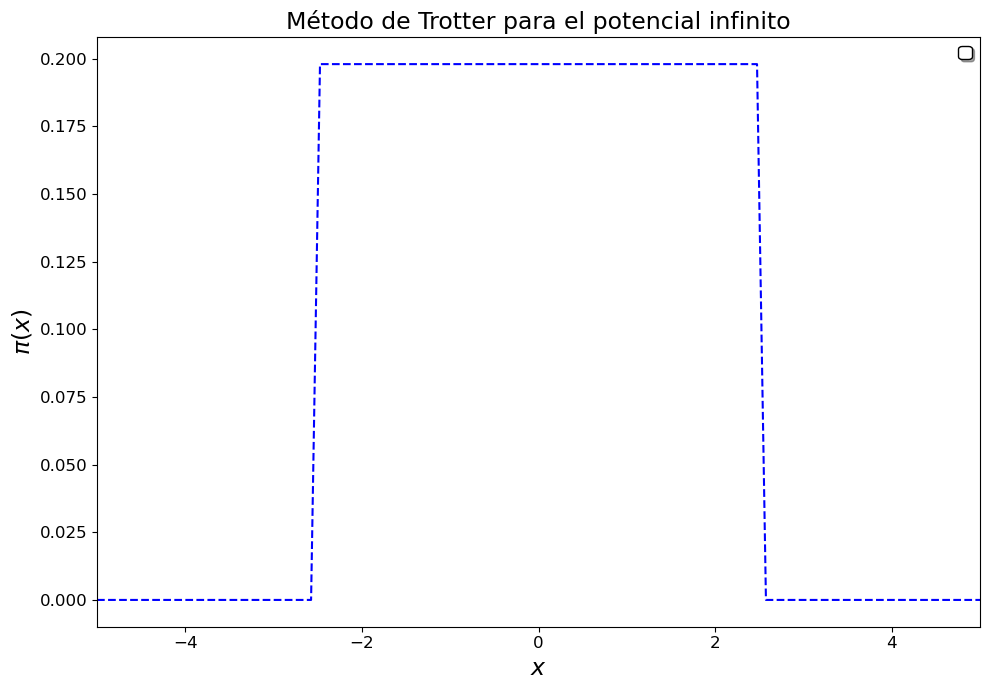

In [32]:
plt.figure(figsize=(10,7))
plt.title('Método de Trotter para el potencial infinito',size=17)
plt.plot(x,pi_of_x3,'--',color='blue')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.xlim(-5,5)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.xticks(fontsize=12)    
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Nótese en el gráfico que, para el potencial infinito, el comportamiento de la función debe estar entre $-L/2$ y $L/2$. En este caso, se está considerando una longitud igual a 2.5. En el gráfico, es posible observar que únicamente los elementos dentro de esta región tendrán una densidad de probabilidad diferente de cero. Este gráfico también nos indica que, para este pozo de potencial con una temperatura bastante baja, todas las posiciones dentro del rango son igual de probables.

In [33]:
beta = 4.0
N = 10
dtau = beta/N
delta = 1.0
n_steps = 1000000
x = [0.0] * N 
x_samples0 = [] 
x_samplesk = []
k_values = 4
x_samplesN = []
paths = []

for step in range(n_steps):
    k = np.random.randint(1,N-1)
    knext , kprev = (k+1) % N, (k-1)%N
    x_new = x[k] + np.random.uniform(-delta,delta)
    old_weight = (rho_free(x[knext], x[k], dtau) * rho_free(x[k] , x[kprev], dtau)*\
                prob(x[k],dtau))
    new_weight = (rho_free(x[knext], x_new, dtau)* rho_free(x_new, x[kprev], dtau)*\
                prob(x_new,dtau))

    if np.random.uniform(0.0,1.0) < min(1,new_weight / old_weight):
        x[k] = x_new
        
    if step % 10 == 0:
        x_samples0.append(x[0])
        x_samplesk.append(x[k_values])
        x_samplesN.append(x[-1])


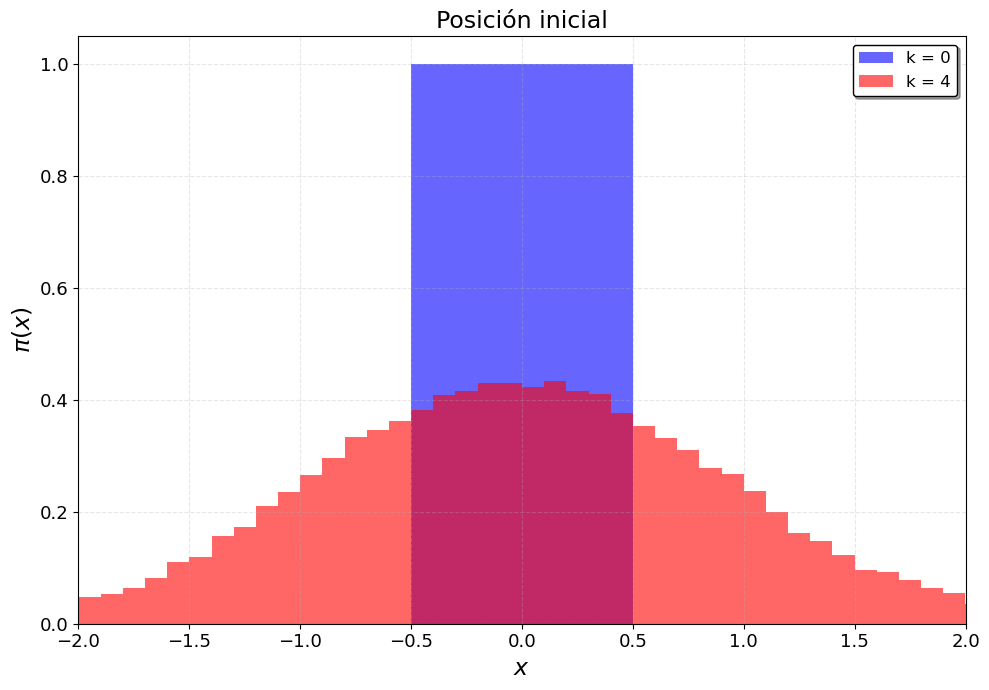

In [34]:
plt.figure(figsize=(10,7))
plt.hist(x_samples0, bins=1, density=True, alpha=0.6, color='blue', label='k = 0')
plt.hist(x_samplesk, bins=50, density=True, alpha=0.6, color='red',label=f'k = {k_values}')
#plt.hist(x_samplesN, bins=50, density=True, alpha=0.6, color='red')
plt.xlabel(r'$x$',size=17)
plt.ylabel(r'$\pi(x)$',size=17)
plt.title(r'Posición inicial',size=17)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(-2,2)
plt.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')
plt.tight_layout()
plt.show()

Mientras que, cuando aplicamos el algoritmo de Metropolis, es posible observar que el comportamiento de la función sigue una distribución bastante parecida a la distribución exponencial, lo cual es más acorde con los resultados teóricos esperados.

Como es posible observar en las dos imágenes anteriores, ambas gráficas deberían ser similares. Sin embargo, tenemos un problema al ejecutar el método con el algoritmo de Trotter. Podría tratarse de un problema con la convergencia o con algún punto dentro del potencial que esté generando el problema. Sin embargo, no fue posible determinar cómo corregir este fallo en el código.

## Conclusiones
En este trabajo, fue posible determinar, a partir de los algoritmos de Metropolis con integrales de camino y el algoritmo de Trotter, una solución computacional para diferentes problemas. Sin embargo, se observó que el algoritmo de Trotter presenta notables diferencias con respecto a los resultados esperados para el potencial de pozo infinito. Como se mencionó en los análisis, esta posible diferencia puede deberse a problemas al definir el potencial en las zonas donde se desea calcular.

Pese a lo anterior, se pudo notar que, por ejemplo, al comparar con los resultados teóricos, el algoritmo de Trotter alcanza una precisión casi exacta con la solución teórica cuántica y también describe el comportamiento clásico cuando se consideran altas temperaturas.

Además, se observó que, cuando se considera el potencial anarmónico, es el término $x^3$ el que introduce la asimetría al problema, lo que hace que, dependiendo del signo de este término, las distribuciones de probabilidad se desplacen más hacia el sentido negativo o positivo.

Se puede concluir que estos dos métodos son viables para desarrollar cálculos computacionales en problemas de potenciales más avanzados sometidos a baños térmicos. Sin embargo, es necesario tener cuidado al utilizar el método de Trotter, ya que, si bien es más exacto y rápido en comparación con el algoritmo de Metropolis, puede presentar discrepancias con los resultados esperados, dependiendo del potencial y los rangos considerados para evaluar el mismo.

## Bibliografía

- Breuer, H.-P., & Petruccione, F. (2002). The Theory of Open Quantum Systems. Oxford University Press.
  
- Hu, B. L., Paz, J. P., & Zhang, Y. (1992). Quantum Brownian motion in a general environment: Exact master equation with nonlocal dissipation and colored noise. Physical Review D, 45(8), 2843.
  
- Newman, M. E. J., & Barkema, G. T. (1999). Monte Carlo Methods in Statistical Physics. Oxford University Press.
  
- Landau, D. P., & Binder, K. (2014). A Guide to Monte Carlo Simulations in Statistical Physics. Cambridge University Press.
  
- Kullback, S., & Leibler, R. A. (1951). On Information and Sufficiency. Annals of Mathematical Statistics, 22(1), 79-86.

  
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian Data Analysis (3rd ed.). CRC Press.

  
- Nagel, A., & Czado, C. (2016). Measuring the goodness of fit of copula models: A review and new approaches. Statistical Science, 31(3), 360-384.

## Agradecimientos 

En primer lugar, deseo expresar mi más profundo agradecimiento a mis padres, cuyo apoyo incondicional, paciencia y motivación han sido el pilar fundamental que me ha sostenido durante todos estos años de formación en física.

Quiero extender un especial reconocimiento a los docentes del Instituto de Física, cuya excelencia académica y dedicación han sido inspiración constante en mi desarrollo profesional. En particular, deseo destacar a aquellos profesores que, a través de metodologías pedagógicas innovadoras y un genuino compromiso con la enseñanza, lograron transmitir no sólo conocimientos teóricos, sino también una profunda pasión por la física y el pensamiento científico. Su influencia ha dejado una huella imborrable en mi formación como científico.

Agradezco igualmente a mis compañeros de estudio, cuyo compañerismo y colaboración han enriquecido significativamente esta experiencia académica. Las discusiones teóricas, las sesiones de estudio y el apoyo mutuo han sido elementos clave en mi proceso de aprendizaje.

Finalmente, reconozco el valioso aporte de todos aquellos investigadores y científicos cuyos trabajos han servido como fundamento para este proyecto. Su contribución al avance del conocimiento ha hecho posible que hoy podamos seguir explorando los misterios del universo físico.